# Utils, Preprocessing

In [1]:
# Import necessary libraries
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/NLP Project')
os.getcwd()

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project'

In [2]:
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from pandas.core.common import flatten
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans

In [ ]:
!pip install --upgrade gensim
!pip install rank_bm25
!pip install ktrain
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
bad_lines_left = []
def bad_lines(row):
  print(len(row), row)
  bad_lines_left.append(row)

original_bad_lines = []
def all_bad_lines(row):
  original_bad_lines.append(row)

columns = ['genre', 'file', 'years', 'id', 'score', 'sentence1', 'sentence2']

train = pd.read_csv('data/sts-train-clean.csv', engine='python', index_col=False, sep='~', quotechar='\x07', header=None, on_bad_lines=bad_lines, names=columns)
dirty_train = pd.read_csv('data/original/sts-train.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'train rows: {len(train)}')
print(f'difference in number of lines: {len(train)-len(dirty_train)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'lines with nan:', len(train[train.isnull().any(axis=1)]), '\n')
train = train.dropna()
bad_lines_left, original_bad_lines = [], []

dev = pd.read_csv('data/sts-dev-clean.csv', engine='python', sep='~', quotechar='\x07', index_col=False, header=None, on_bad_lines=bad_lines, names=columns)
dirty_dev = pd.read_csv('data/original/sts-dev.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'dev rows: {len(dev)}')
print(f'difference in number of lines: {len(dev)-len(dirty_dev)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'lines with nan:', len(dev[dev.isnull().any(axis=1)]), '\n')
dev = dev.dropna()
bad_lines_left, original_bad_lines = [], []

test = pd.read_csv('data/sts-test-clean.csv', engine='python', sep='~', quotechar='\x07', index_col=False, header=None, on_bad_lines=bad_lines, names=columns)
dirty_test = pd.read_csv('data/original/sts-test.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'test rows: {len(test)}')
print(f'difference in number of lines: {len(test)-len(dirty_test)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'test with nan:', len(test[test.isnull().any(axis=1)]), '\n')
test = test.dropna()
bad_lines_left, original_bad_lines = [], []


train rows: 5749
difference in number of lines: 1571
bad lines left: 0
lines with nan: 0 

dev rows: 1500
difference in number of lines: 537
bad lines left: 0
lines with nan: 0 

test rows: 1379
difference in number of lines: 347
bad lines left: 0
test with nan: 0 



In [4]:
train_df = train[['sentence1', 'sentence2', 'score']].copy()
test_df = dev[['sentence1', 'sentence2', 'score']].copy()

train_df['score'] = train_df['score'].astype(float)
test_df['score'] = test_df['score'].astype(float)

test_results = dev.copy()
train_results = train.copy()

test_targets = test_df['score'].values
train_targets = train_df['score'].values

# Preliminary work

What type of documents does the dataset contain?

The dataset contains pairs of short text passages, either written by humans or generated by a language model. 

In [ ]:
# print(len(train_df) + len(test_df) + len(test_df))

The entire dataset consists of 8555 pairs of text passages. 

These pairs of passages are given a score 1-5 based on how similar the meaning of the two passages are. Where a score of 5 would mean that the passages has exactly the same meaning, while a score of 1 means that the passages do not have the same meaning at all. 

In [ ]:
train_passages = train_df['sentence1'].to_list() + train_df['sentence2'].to_list() 
# dev_passages = dev_df['sentence1'].to_list() + dev_df['sentence2'].to_list()
test_passages = test_df['sentence1'].to_list() + test_df['sentence2'].to_list()

In [ ]:
print(f"Number of passages in train_df: {len(train_df)*2}")
# print(f"Number of passages in   dev_df:  {len(dev_df)*2}")
print(f"Number of passages in  test_df:  {len(test_df)*2}")
# print(f"Number of passages in    total: {(len(test_df) + len(train_df) + len(dev_df))*2}")
print(f"Number of passages in    total: {(len(test_df) + len(train_df))*2}")

Number of passages in train_df: 11498
Number of passages in  test_df:  3000
Number of passages in    total: 14498


In [ ]:
# passages = train_passages + dev_passages + test_passages 
passages = train_passages + test_passages 

word_count = []
for passage in passages: 
    word_count.append(len(passage.split()))

avg_word_count = sum(word_count) / len(word_count)
print(f"Average passage word count: {avg_word_count}")

Average passage word count: 10.242309284039179


In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [ ]:
vectorizer.fit(train_passages)

TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [ ]:
vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 2910


In [ ]:
train_vectorized = vectorizer.transform(train_passages)

In [ ]:
from collections import Counter

train_scores = train_df['score']
# dev_scores = dev_df['score']
test_scores = test_df['score']

train_score_count = dict(Counter(train_scores))
# dev_score_count = dict(Counter(dev_scores))
test_score_count = dict(Counter(test_scores))

In [ ]:
print(train_score_count)
# print(dev_score_count)
print(test_score_count)

{5.0: 266, 3.8: 267, 2.6: 157, 4.25: 41, 0.5: 23, 1.6: 137, 2.2: 172, 4.2: 204, 4.6: 163, 3.867: 1, 4.667: 3, 1.667: 4, 3.75: 70, 3.2: 252, 2.8: 176, 3.0: 315, 4.8: 135, 4.0: 354, 4.909: 1, 2.4: 152, 3.4: 261, 2.75: 37, 3.6: 230, 1.75: 24, 1.0: 212, 2.375: 1, 4.4: 163, 4.75: 24, 1.556: 2, 3.938: 1, 3.5: 57, 1.4: 159, 3.833: 2, 0.6: 111, 2.917: 1, 2.0: 194, 0.8: 137, 1.643: 1, 2.25: 22, 4.857: 1, 2.533: 2, 0.143: 1, 2.5: 37, 0.0: 367, 0.4: 133, 0.667: 3, 4.133: 1, 1.2: 139, 3.765: 1, 3.941: 1, 0.25: 18, 3.25: 67, 0.75: 17, 1.5: 25, 0.2: 64, 3.111: 1, 1.286: 1, 1.8: 147, 0.85: 1, 3.923: 1, 1.25: 14, 0.833: 1, 0.333: 4, 3.333: 21, 4.333: 6, 2.667: 7, 0.417: 1, 2.818: 2, 3.533: 2, 0.643: 1, 1.583: 1, 1.778: 1, 3.667: 7, 2.333: 5, 1.7: 1, 4.5: 26, 0.727: 1, 1.333: 6, 0.067: 1, 4.875: 1, 3.615: 1, 2.875: 1, 4.091: 2, 2.769: 1, 2.583: 1, 3.929: 2, 0.231: 1, 0.118: 1, 4.1: 2, 2.33: 3, 0.17: 1, 3.67: 1, 2.83: 1, 3.1: 2, 2.11111111111111: 2, 1.1: 2, 3.77777777777778: 2, 4.57142857142857: 3, 2.46

In [ ]:
train_score, train_count = zip(*sorted(train_score_count.items()))
# dev_score, dev_count = zip(*sorted(dev_score_count.items()))
test_score, test_count = zip(*sorted(test_score_count.items()))

# plt.plot(train_score, train_count)
# plt.show()
# plt.plot(dev_score, dev_count)
# plt.show()
# plt.plot(test_score, test_count)
# plt.show()

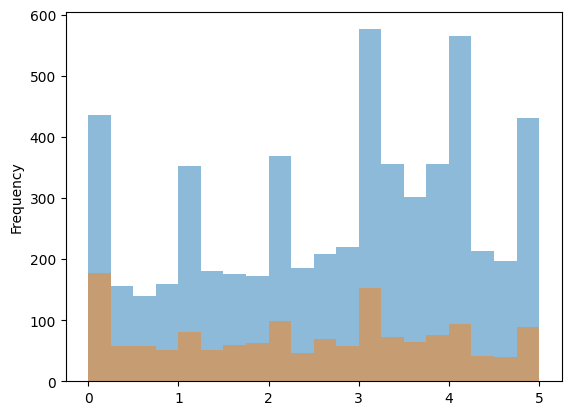

In [ ]:
bins = [i for i in np.arange(0, 5.25, 0.25)]

train_score_count_df = pd.DataFrame.from_dict(train_score_count, orient='index', columns=['count'])
# train_score_count_df = pd.DataFrame.from_dict(data=train_score_count, orient='index', columns=['score', 'count'])
# dev_score_count_df = pd.DataFrame.from_dict(data=dev_score_count, orient='index', columns=['score', 'count'])
# test_score_count_df = pd.DataFrame.from_dict(data=test_score_count, orient='index', columns=['score', 'count'])

# print(train_score_count_df)

binned_train_scores = pd.cut(train_df['score'], bins)

# print(binned_train_scores.value_counts())

ax = train_df['score'].plot.hist(bins=20, alpha=0.5)
# dev_ax = dev_df['score'].plot.hist(bins=20, alpha=0.5)
test_ax = test_df['score'].plot.hist(bins=20, alpha=0.5)


# Word embedding using Word2Vec

In [5]:
train_sentences = list(flatten(train_df['sentence1'])) + list(flatten(train_df['sentence1'])) 
test_sentences = list(flatten(test_df['sentence1'])) + list(flatten(test_df['sentence1'])) 

train_sentences_token = [re.sub('\W', ' ', sentence).lower().split() for sentence in train_sentences]
test_sentences_token = [re.sub('\W', ' ', sentence).lower().split() for sentence in test_sentences]


In [6]:
w2v_model = Word2Vec(train_sentences_token, vector_size=30, min_count=5, window=10)


In [ ]:
len(w2v_model.wv)

2955

The previous cell shows the vocab length of the W2V. A vocabulary of 2955 words is not a lot, but considering the length of the passages it's not that surprising. 

Checking what words the Word2Vec model finds most similar to the word 'plane': 

In [ ]:
w2v_model.wv.most_similar('plane')

[('dies', 0.9979137182235718),
 ('shooting', 0.997574508190155),
 ('include', 0.9972814917564392),
 ('between', 0.9968286156654358),
 ('rape', 0.9967337250709534),
 ('house', 0.9967323541641235),
 ('london', 0.9967234134674072),
 ('their', 0.9967067837715149),
 ('fraud', 0.9966479539871216),
 ('backs', 0.9966195225715637)]

In [7]:
sample = random.sample(list(w2v_model.wv.key_to_index), 2924)

Getting the word vectors down to 3 dimentions such that we can plot them in a 3D plot. 

In [8]:
word_vectors = w2v_model.wv[sample]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

In [9]:
x, y, z = np.transpose(tsne_embedding)

In [ ]:
fig = px.scatter(x, y, z)
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

In [11]:
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
# fig = px.scatter_3d(x=x,y=y,z=z,text=sample)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

In order to find out how large k should be while using kmeans, we used the elbow-method. 

In [ ]:
k_values = range(1, 11)  # Adjust the range as needed

# Initialize an empty list to store the within-cluster sum of squares (WCSS)
wcss = []

# Calculate WCSS for each K value
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(word_vectors)
    wcss.append(kmeans.inertia_)

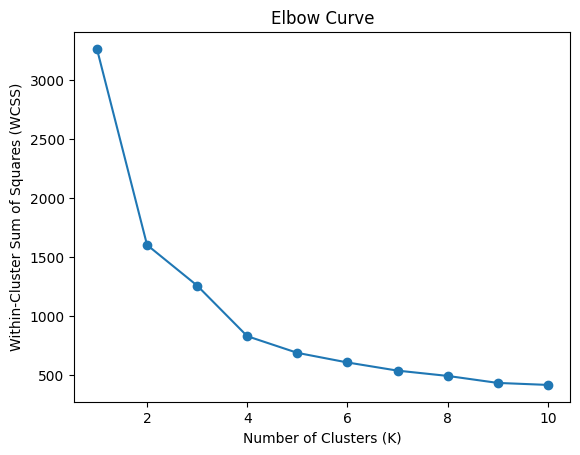

In [ ]:
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Curve')
plt.show()

We made it out from the plot that 4 is a suitable number of clusters. Even though the largest elbow is at 2, there is a quite distinct elbow at 4 as well. 

In [ ]:
num_clusters = 4  # Choose the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
kmeans.fit(word_vectors)

# Get cluster assignments
cluster_labels = kmeans.labels_

In [ ]:
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

print(tsne_embedding)

x, y, z = np.transpose(tsne_embedding)

[[  8.703989    -4.883939   -11.856592  ]
 [-13.115737    10.984024     1.1334752 ]
 [-19.671824     5.040267    -4.5657306 ]
 ...
 [ -7.5272384   -8.569614     3.2589447 ]
 [-12.456322     5.710221    -2.740534  ]
 [-14.570679    -6.6103373    0.91563606]]


<ipython-input-184-b3d193ea6e00>:10: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



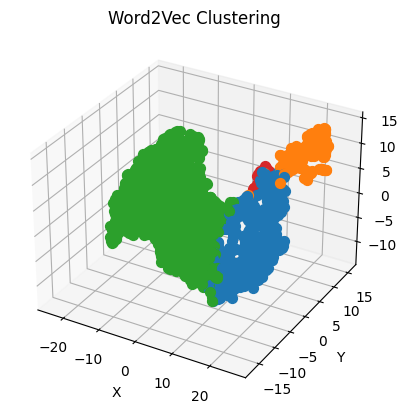

In [ ]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a color map for the clusters
color_map = plt.colormaps.get_cmap('tab10')

# Plot the points and color them based on cluster labels
for i, (x, y, z) in enumerate(tsne_embedding):
    ax.scatter(x, y, z, c=color_map(cluster_labels[i]), s=50)

# Set labels for each axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set a title for the plot
ax.set_title('Word2Vec Clustering')

# Show the plot
plt.show()

In [ ]:
scatter = go.Scatter3d(
    x=[vec[0] for vec in tsne_embedding],
    y=[vec[1] for vec in tsne_embedding],
    z=[vec[2] for vec in tsne_embedding],
    mode='markers',
    marker=dict(
        color=cluster_labels,
        size=5,
        colorscale='Viridis',
        opacity=0.8
    ), 
    text=sample
)

# Create the layout for the plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    ),
    title='Word2Vec Clustering'
)

# Create the figure and add the scatter plot
fig = go.Figure(data=[scatter], layout=layout)

# Display the figure
fig.show(renderer='colab')

# Clustering – Tests


In [ ]:
import nltk
import gensim
import ktrain
import torch
import os
import re
import pandas as pd
import numpy as np
import gensim.downloader as api
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, r2_score
from rank_bm25 import BM25Okapi
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sentence_transformers import SentenceTransformer, util
from torch.utils.data import DataLoader, Dataset, RandomSampler
from ktrain import text
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from absl import logging

In [ ]:
def get_results(targets, preds):
  mse = mean_squared_error(targets, preds)
  rmse = mean_squared_error(targets, preds, squared=False)
  r2 = r2_score(targets, preds)

  print(f"MSE: {round(mse, 3)}")
  print(f"RMSE: {round(rmse, 3)}")
  print(f"R2: {round(r2, 3)}\n")

  return mse, rmse, r2

In [ ]:
device = torch.device('cuda')

ST_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)

test_results = test_df.copy()
train_results = train_df.copy()

test_targets = test_df['score'].copy()
train_targets = train_df['score'].copy()



def miniLM(df, results, targets):
  train_sentences1 = df['sentence1'].values
  train_sentences2 = df['sentence2'].values

  #Compute embedding for both lists
  embedding_1 = ST_model.encode(train_sentences1, convert_to_tensor=True)
  embedding_2 = ST_model.encode(train_sentences2, convert_to_tensor=True)

  MiniLM_similarity = torch.diagonal(util.pytorch_cos_sim((embedding_1), (embedding_2))).cpu()
  MiniLM_similarity[MiniLM_similarity < 0] = 0 # Sentences that are opposing should just be zero
  MiniLM_similarity = MiniLM_similarity * 5
  results['miniLM_score'] = MiniLM_similarity
  get_results(targets, MiniLM_similarity)

miniLM(train_df, train_results, train_targets)
miniLM(test_df, test_results, test_targets)

MSE: 0.947
RMSE: 0.973
R2: 0.558

MSE: 0.788
RMSE: 0.887
R2: 0.65



In [ ]:
import scipy.cluster.hierarchy as sch
import plotly.figure_factory as ff

def miniLM_hierarchical_clustering(df):
    train_sentences1 = df['sentence1'].values
    train_sentences2 = df['sentence2'].values

    # Compute embedding for both lists
    embedding_1 = ST_model.encode(train_sentences1, convert_to_tensor=True)
    embedding_2 = ST_model.encode(train_sentences2, convert_to_tensor=True)

    # Calculate pairwise cosine similarity
    similarity_matrix = util.pytorch_cos_sim(embedding_1, embedding_2).cpu()

    # Perform hierarchical clustering
    linkage_matrix = sch.linkage(similarity_matrix, method='complete')

    # Create an interactive dendrogram using plotly
    dendrogram_fig = ff.create_dendrogram(
        linkage_matrix,
        orientation='left'
    )

    # Configure the layout
    dendrogram_fig.update_layout(
        title="Hierarchical Clustering Dendrogram",
        xaxis_title="Distance",
        yaxis_title="Sentence Index"
    )

    # Display the interactive dendrogram
    dendrogram_fig.show()

    # Return the linkage matrix
    return linkage_matrix

miniLM_hierarchical_clustering(train_df[:500])
# miniLM_hierarchical_clustering(test_df, test_results, test_targets)

array([[ 12.        , 122.        ,   0.        ,   2.        ],
       [380.        , 478.        ,   0.        ,   2.        ],
       [  6.        , 486.        ,   0.        ,   2.        ],
       ...,
       [994.        , 995.        ,   7.3109134 , 298.        ],
       [992.        , 993.        ,   8.06718386, 202.        ],
       [996.        , 997.        ,   8.88527556, 500.        ]])

# Clustering 

We were not satisfied with the results ofd the Word2Vec embedding and clustering. The nodes in the clusters seemed almost random, with some clusters haveing words that are related. Therefore, we decidede to try hierarchical clustering using SentenceTransformer and MiniLM as a model. As this can be quite computationally intensive, we have used the 500 first sentence pairs giving us 1000 sentences. 

In [ ]:
device = torch.device('cuda')
ST_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)

In [ ]:
import scipy.cluster.hierarchy as sch
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import dendrogram

def miniLM_hierarchical_clustering(df):
    train_sentences1 = df['sentence1'].values
    train_sentences2 = df['sentence2'].values

    sentences = np.concatenate((train_sentences1, train_sentences2), axis=0)

    # Compute embedding for the concatenated list
    embedding = ST_model.encode(sentences)

    # Normalizing the embedding
    embedding = embedding /  np.linalg.norm(embedding, axis=1, keepdims=True)

    # Perform hierarchical clustering
    clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)
    clustering_model.fit(embedding)
    cluster_assignment = clustering_model.labels_

    # Printing the content of all clusters
    clustered_sentences = {}
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        if cluster_id not in clustered_sentences:
            clustered_sentences[cluster_id] = []

        clustered_sentences[cluster_id].append(sentences[sentence_id])

    for i, cluster in clustered_sentences.items():
        print("Cluster ", i+1)
        print(cluster)
        print("")

    return embedding, clustering_model, sentences

In [ ]:
embedding, clustering_model, sentences = miniLM_hierarchical_clustering(train_df[:500])

Cluster  88
['A plane is taking off.', 'An airplane is flying in the air.', 'An air plane is taking off.', 'A South African Airways plane is flying in a blue sky.']

Cluster  106
['A man is playing a large flute.', 'A man is playing a flute.', 'A man is playing a flute.', 'A man plays the flute.', 'A man is playing a flute in a band.', 'A man is playing a wooden flute while several other men play bongo drums.', 'A man is playing a flute.', 'A man is playing a bamboo flute.', 'A man is playing the flute.', 'A man is playing a flute.', 'A man is playing a flute.', 'A man is playing flute.', 'A man is playing a flute.', 'A man is playing a flute.']

Cluster  23
['A man is spreading shreded cheese on a pizza.', 'The man is eating pizza.', 'A man puts some cheese on a pizza.', 'A man is smelling two pizzas.', 'A man is spreading shredded cheese on an uncooked pizza.', 'A man is eating a slice of pizza.', 'The man sprinkled cheese on the pizza.']

Cluster  38
['Three men are playing chess.',

As we can see from the printed clusters, the sentence clustering is quite good. 

In [ ]:
def plot_dendrogram(model, **kwargs):

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Create the linkage matrix
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

    # return dendrogram(linkage_matrix, no_plot=True)

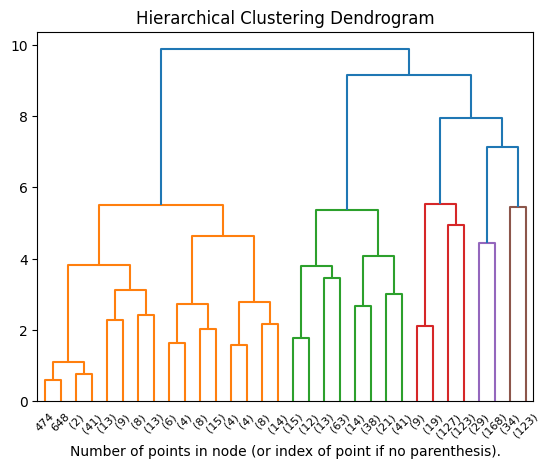

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clustering_model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

From the dendrogram, we can see that there are many clusters, we have set the level cutoff at 4 levels, but that the clusters are in 5 main "clusters" of approximately equal size. 

In [ ]:
def get_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return dendrogram(linkage_matrix, no_plot=True)

In [ ]:
dendrogram = get_dendrogram(clustering_model)

Cluster 9: Two women are wrestling. (134, 0)
Cluster 9: Two women are wrestling on the floor. (634, 0)
Cluster 88: A woman is resting in a floating raft. (330, 0)
Cluster 88: People ride and paddle a raft. (339, 0)
Cluster 88: Four people are floating on a raft. (839, 0)
Cluster 8: Three teenage girls danced in the room. (257, 0)
Cluster 8: Some teenage girls are dancing for the camera. (757, 0)
Cluster 8: A group of people dance on a hill. (165, 0)
Cluster 8: A group of people are dancing. (665, 0)
Cluster 8: A boy is making some dance steps. (345, 0)
Cluster 8: Three boys are dancing. (241, 0)
Cluster 8: Kids are dancing. (741, 0)
Cluster 160: A woman is dancing and singing with other women. (32, 0)
Cluster 160: A woman is dancing with other women. (343, 0)
Cluster 160: Three women are dancing. (176, 0)
Cluster 160: The ladies are performing a dance. (927, 0)
Cluster 104: A woman is dancing by a fire. (238, 0)
Cluster 104: A woman is dancing in the street. (860, 0)
Cluster 104: A wom

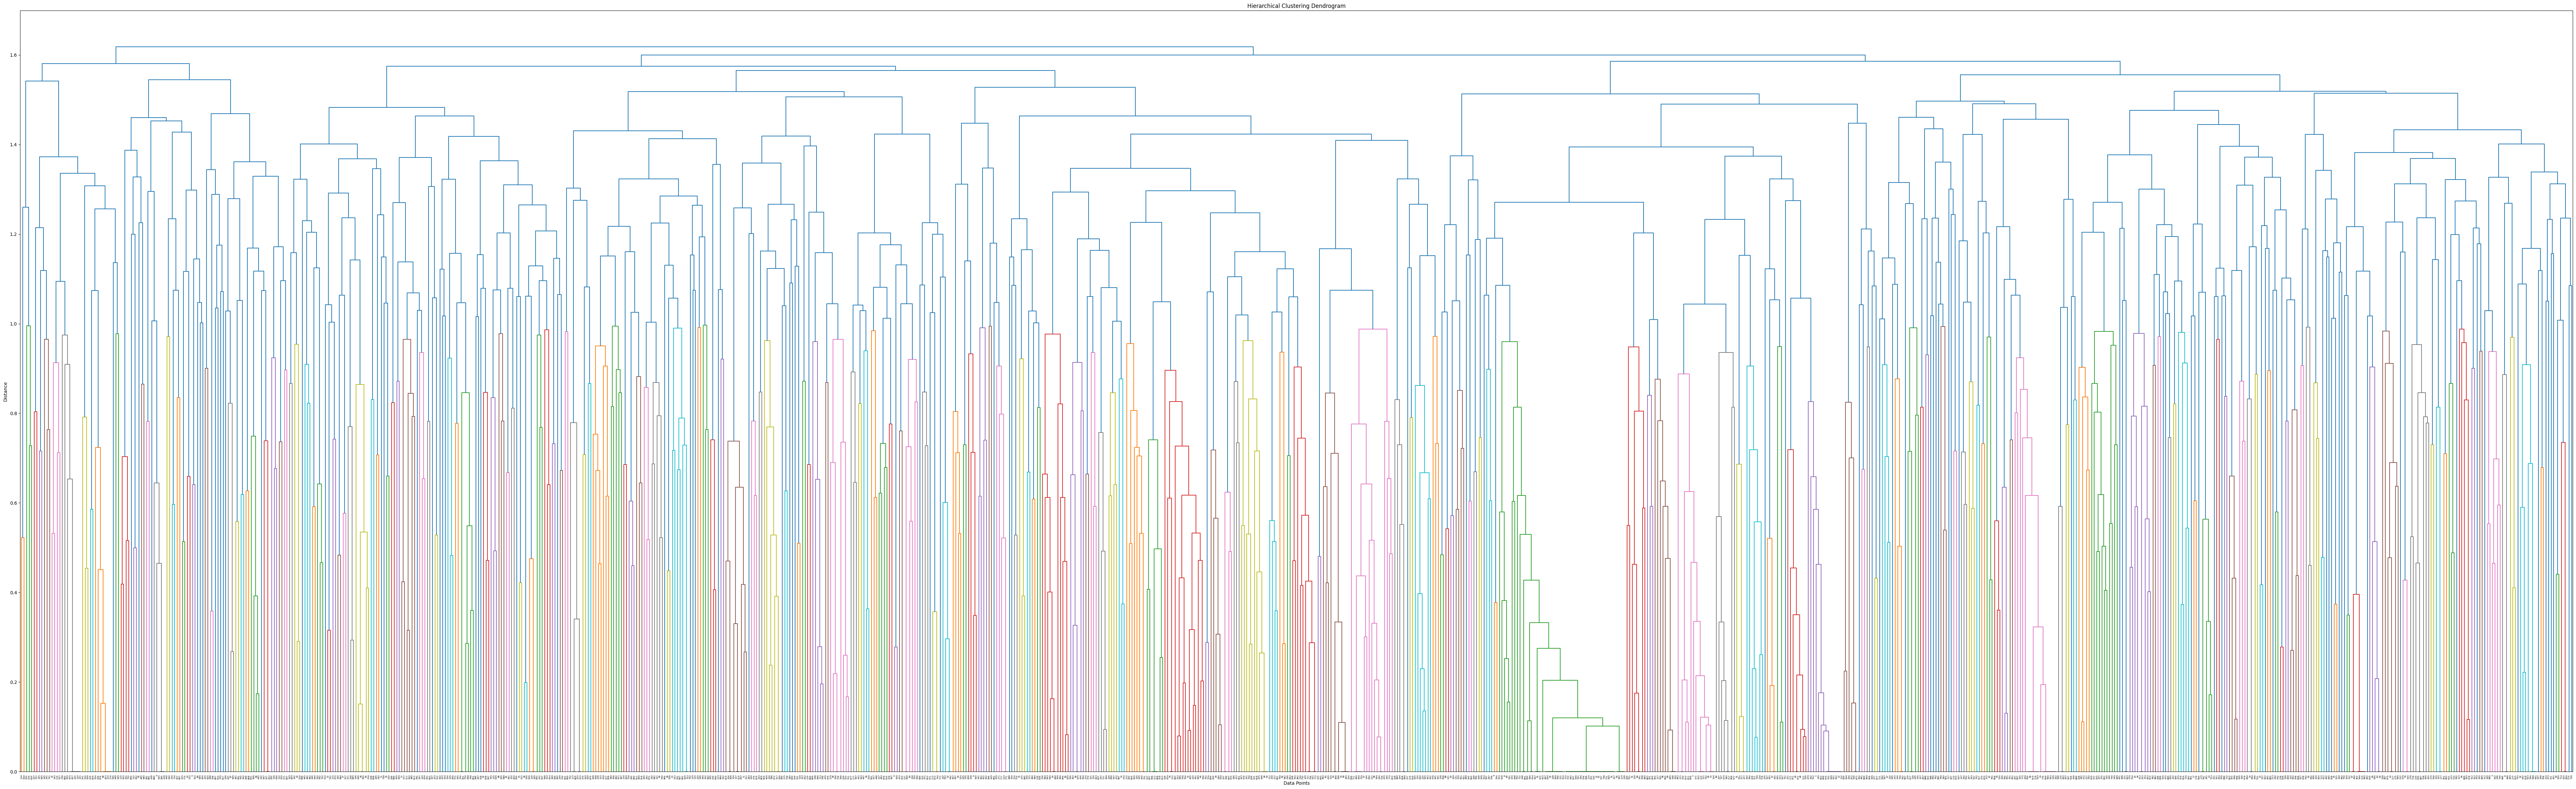

In [ ]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Compute the linkage matrix using hierarchical clustering
linkage_matrix = sch.linkage(embedding, method='complete')

# Plot the dendrogram
plt.figure(figsize=(100, 30))
dendrogram = sch.dendrogram(linkage_matrix, color_threshold=1.0)  # Set the color threshold

# Add cluster labels to the leaves
leaf_indices = dendrogram['leaves']
leaf_labels = [sentences[idx] for idx in leaf_indices]
cluster_labels = clustering_model.labels_[leaf_indices]  # Assuming you have the cluster assignments

for idx, label, cluster in zip(leaf_indices, leaf_labels, cluster_labels):
    print(f"Cluster {cluster}: {label}", (idx, 0))

# Customize the plot
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')

# Display the plot
plt.show()

The last dendrogram is of all sentences and their connection to eachother. 